## Compare monthly versus daily resolution discharge data on calculations of L_scour


In [1]:
__author__ = "Sam Brooke"
__email__ = "sbrooke@ucsb.edu"

import math
import pandas as pd
import numpy as np
import csv
import os
import random
import pickle


num_reps = 20000 # For Monte Carlo


# General parameters when otherwise not specified

R = 1.65 # Submerged specific gravity for quartz
g = 9.81 # gravity


<h2>Trampush et al. 2014 - Global Slope-Depth Regression</h2>

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

font = {'family' : 'arial',
        'size'   : 14}

mpl.rc('font', **font)

# Trampush et al. 2014 Slope-Depth-Grain size coefficients
# log(S) =  alpha_0 + alpha_1 log(D50) + alpha_2 log(Hbf)
alpha_0 = -2.08
alpha_0_std = 0.036
alpha_1 = 0.254
alpha_1_std = 0.016
alpha_2 = -1.09
alpha_2_std = 0.044

# Do not vary Trampush constants
alpha_0_samples = np.full((num_reps,), alpha_0) 
alpha_1_samples = np.full((num_reps,), alpha_1)
alpha_2_samples = np.full((num_reps,), alpha_2)

scour_df_original = pd.DataFrame({'alpha_0': alpha_0_samples, 'alpha_1':alpha_1_samples, 'alpha_2':alpha_2_samples})

Hbf_trampush = lambda S, D50, alpha_0, alpha_1, alpha_2: math.exp((np.log10(S) - alpha_0 - (alpha_1 * 
                             np.log10(D50)))/alpha_2)


<h2>Dunne and Jerolmack, 2018 - Bank cohesion relation for depth</h2>

<br>
\begin{equation}
H_{bf} = \frac{1.2\tau_c}{\rho g S}
\end{equation}

In [3]:
# S = slope, tc = critical shear stress, rho = density of water, g = gravitational acceleration

Hbf_Dunne = lambda S, tc, rho, g: (1.2*tc)/(rho*g*S)


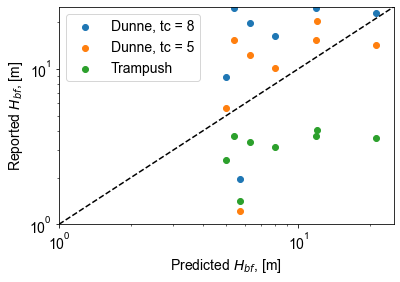

We will sample depths from both


In [4]:
# Compare Dunne and Trampush for global river compilation

avulsions_global_df = pd.read_csv('./daily_vs_monthly_river_comparison_list.csv') # Global compilation from Ganti et al. 2019

rivs = avulsions_global_df.River

hbf_trampush = []
hbf_dunne = []
hbf_dunne_5 = []
for index, row in avulsions_global_df.iterrows():
    hbf_dunne.append(Hbf_Dunne(row['S (x10-4)']/10000, 8, 1000, 9.81))
    hbf_dunne_5.append(Hbf_Dunne(row['S (x10-4)']/10000, 5, 1000, 9.81))
    hbf_trampush.append(Hbf_trampush(row['S (x10-4)']/10000, row['D50 [mm]']/1000, alpha_0, alpha_1, alpha_2))
                        
sc1 = plt.scatter(avulsions_global_df['Hc [m]'], hbf_dunne)
sc3 = plt.scatter(avulsions_global_df['Hc [m]'], hbf_dunne_5)
sc2 = plt.scatter(avulsions_global_df['Hc [m]'], hbf_trampush)
plt.xscale("log", nonpositive='clip')
plt.yscale("log", nonpositive='clip')
plt.ylim(bottom=1, top=25)
plt.xlim(left=1, right=25)
plt.plot([0,25], [0,25], 'k--')
plt.legend([sc1,sc3,sc2],['Dunne, tc = 8', 'Dunne, tc = 5', 'Trampush', ], loc='upper left')
plt.xlabel('Predicted $H_{bf}$, [m]')
plt.ylabel('Reported $H_{bf}$, [m]')


plt.show()

print('We will sample depths from both')

<h3>$l_{scour}$ Table Collation and Functions</h3>

In [5]:
def n_Ma(D50):
    # Ma et al. [2017] n exponent
    return (1.322 / (1 + math.exp(math.pow(10,5) * ((-1 * D50) + (1.6 * math.pow(10, -4))  )))) + 1.678
      
def a_Ma(D50):
    # Ma et al. [2017] alpha exponent
    return (0.859 / (1 + math.exp(math.pow(10,5) * (D50 - (1.6 * math.pow(10, -4))  )))) + 0.036

    
def Hbf_t(row): # Flow depth from Trampush et al., 2014
    return Hbf_trampush(row['S'], row['D50'], row['alpha_0'], 
                        row['alpha_1'], row['alpha_2'])

def Hbf_d(row): # Flow depth from Dunne and Jerolmack, 2018
    # Bank shear stress is between 6 and 10 Pa
    return Hbf_Dunne(row['S'], random.randrange(6, 11, 1), 1000, 9.78)

def Hbf_either(row): # Choose randomly whether to use flow depth from Dunne and Jerolmack, 2018 or Trampush 2014
    
    hc_dunne = Hbf_Dunne(row['S'], random.randrange(6, 11, 1), 1000, 9.78)
    hc_trampush = Hbf_trampush(row['S'], row['D50'], row['alpha_0'], 
                        row['alpha_1'], row['alpha_2'])
    
    if random.randrange(0, 2, 1): # 1 = Trampush 0 = D & J
        return hc_trampush
    else:
        return hc_dunne
    
def L_b(row): # Characteristic Backwater Length
    Hc = float(row['Hbf'])
    S = float(row['S'])
    return  Hc/S

def l_scour(row): # Calculate l_scour
    
#     print(row)
    
    Cf = float(row['Cf'])
    g = float(row['g'])
    R = float(row['R'])
    alpha_0 = float(row['alpha_0'])
    alpha_1 = float(row['alpha_1'])
    alpha_2 = float(row['alpha_2'])
    Hn = float(row['Hn'])
    Hc = float(row['Hbf'])
    S = float(row['S'])
    D50 = float(row['D50'])
    a_ma = float(a_Ma(D50))
    n_ma = float(n_Ma(D50))
    tscour = float(row['t_scour'])
    Lb = float(row['L_b'])
    
#     print('R = '+str(R))
#     print('t_scour = '+str(tscour))
#     print('g = '+str(g))
#     print('S = '+str(S))
#     print('alpha_0 = '+str(alpha_0))
#     print('alpha_1 = '+str(alpha_1))
#     print('alpha_2 = '+str(alpha_2))
#     print('D50 = '+str(D50))
#     print('n_ma = '+str(n_ma))
#     print('a_ma = '+str(a_ma))
#     print('Hbf = '+str(Hc))
#     print('Hn = '+str(Hn))
#     print('L_b = '+str(Lb))
    
    lscour_top = np.sqrt(R*g*(np.power(D50,3)))*a_ma*np.power(Hn*S, n_ma)
    lscour_bottom = Hc*Lb*Cf*np.power(R*D50,n_ma)
    lscour_Lb = np.power(tscour * (lscour_top/lscour_bottom), 0.5)
    lscour = lscour_Lb*Lb

    return lscour
        

def tau_star(row): # Ma et al., 2017

    R = float(row['R'])
    Hc = float(row['Hbf'])
    S = float(row['S'])
    D50 = float(row['D50'])
            
    return (Hc*S)/(R*D50)
    
def qs_star(row): # Dimensionless sediment discharge
    
    D50 = float(row['D50'])
    Cf = float(row['Cf'])
    a_ma = float(a_Ma(D50))
    n_ma = float(n_Ma(D50))
    tscour = float(row['t_scour'])
    Lb = float(row['L_b'])
    tau_star = float(row['tau_star'])
    
    return (a_ma*np.power(tau_star, n_ma))/Cf
    
def qs(row): # unit sediment discharge
    
    R = float(row['R'])
    g = float(row['g'])
    D50 = float(row['D50'])
    qs_star = float(row['qs_star'])
    
    return qs_star*np.sqrt(R*g*np.power(D50,3))


def Te_star(row): # Te* - dimensionless flow duration
    
    t_scour = float(row['t_scour'])
    Hc = float(row['Hbf'])
    Lb = float(row['L_b'])
    qs = float(row['qs'])
    
    return (t_scour*qs)/(Lb*Hc)


## $T_{scour}$

In [6]:
# Create discharge database from monthly data only

flood_df_daily = pd.read_csv('./discharge_data/compilations/COMPILATION_flood_Qbf_Global_Daily.csv')
flood_df_monthly_global = pd.read_csv('./discharge_data/compilations/COMPILATION_flood_Qbf_Global_Monthly.csv')
flood_df = flood_df_monthly_global.append(flood_df_daily).reset_index(drop=True)


<h2>Calculate $L_{scour}$</h2>

<h3>Global Avulsions Data (Ganti et al., 2019) -- Monthly Resolution Discharge Data</h3>

In [7]:
# Target columns for table
delta_rivers = []
river_classification = [] # This study or global dataset [study|global]
La_list = [] # Observed avulsion lengths [km]
La_error = []
Lscour_list = [] # Flood scour lengths [km]
Lscour_error = []
Lb_list = [] # Characteristic backwater lengths [km]
Lb_error = []
Tscour_list = [] # Flood scour duration (T_scour) lists [km]
Tscour_std = []
Tscour_std_error = []
Tscour_source = [] # RivDis, GRDC etc.
S_list = [] # Slope lists
S_error = []
Hbf_list = [] # Characteristic flow depth [m]
Hbf_error = []
D50_list = [] # Median grain size [m]
Cf_list = [] # Coefficient of friction

Tscour_data_res = [] # MONTHLY | DAILY

Lb_std_error = [] # Lb standard error
Lscour_std_error = [] # Lscour standard error

qs_list = []
qs_std_list = []
qs_std_err_list = []

qs_star_list = []
qs_star_std_list = []
qs_star_std_err_list = []

tau_star_list = []
tau_star_std_list = []
tau_star_std_err_list = []

Te_star_list = []
Te_star_std_list = []
Te_star_std_err_list = []


# Hn - uniform distribution from flood multiples (Hn = Hc*flood_multiple)
flood_multiple = []
for _ in range(num_reps): flood_multiple.append(random.randrange(2, 5, 1)) # Floods are between 2 and 4 time bankfull
# e.g. (Gibling 2006; Ganti et al. 2014a; Trower et al. 2018; Ganti et al., 2019)

avulsions_global_df = pd.read_csv('./daily_vs_monthly_river_comparison_list.csv') # Global compilation from Ganti et al. 2019

river_ids = avulsions_global_df['River']

for r in river_ids:
    
    if r == 'nan':
        continue
        
    print(r)

    river_classification.append('global')
    
    av_df = avulsions_global_df.loc[avulsions_global_df['River'] == r]
    
    delta_rivers.append(av_df['river_name'].iloc[0].lower())
    
    # Flood duration and recurrence interval

    fl_df = flood_df.loc[(flood_df['River'] == r) & (flood_df['Data'] == 'MONTHLY')]
    
    t_scour_mean = fl_df['Tscour (months)'].iloc[0]
    t_scour_err = fl_df['Tscour std. err.'].iloc[0]
    t_scour_source = fl_df['Source'].iloc[0]
    
    # Monte Carlo for T_scour
    seconds_in_month = 2.628e+6
    tscour_riv = np.random.normal(loc=t_scour_mean, scale=t_scour_err, size=(num_reps,))*seconds_in_month
    tscour_riv[tscour_riv<0] = np.nan
    
    S = av_df['S (x10-4)'].iloc[0]*0.0001
    D50 = av_df['D50 [mm]'].iloc[0]/1000
    Cf = av_df['Cf'].iloc[0]
    Hbf = av_df['Hc [m]'].iloc[0]
    scour_df = scour_df_original.copy()
    scour_df['River'] = av_df['river_name'].iloc[0].lower().capitalize()
    scour_df['S'] = S
    scour_df['D50'] = D50
    scour_df['Cf'] = Cf
    scour_df['g'] = g
    scour_df['R'] = R
    scour_df['Hbf'] = av_df['Hc [m]'].iloc[0]
    scour_df['Flood_multiple'] = flood_multiple # What multiple of Hbf are we using (2-4x)
    scour_df['Hn'] = scour_df['Hbf']*scour_df['Flood_multiple']
    scour_df['t_scour'] = tscour_riv
    scour_df['L_b'] = av_df['Lb [km]'].iloc[0]*1000
    scour_df['l_scour'] = scour_df.apply(l_scour, axis=1)
    scour_df['L_A'] = av_df['LA [km]'].iloc[0]*1000
    
    scour_df['tau_star'] = scour_df.apply(tau_star, axis=1)
    scour_df['qs_star'] = scour_df.apply(qs_star, axis=1)
    scour_df['qs'] = scour_df.apply(qs, axis=1)
    scour_df['Te_star'] = scour_df.apply(Te_star, axis=1)
    
    Tscour_data_res.append('MONTHLY')
    
    lscour_mean = scour_df['l_scour'].mean()
    lscour_std = scour_df['l_scour'].std()
    lb_mean = scour_df['L_b'].mean()
    lb_std = scour_df['L_b'].std()
    La_list.append(av_df['LA [km]'].iloc[0])
    La_error.append(av_df['LA error [km]'].iloc[0])
    
    # Representative L_scour values (using just the mean values)
    D50_rep = D50
    S_rep = S
    Hbf_rep = Hbf
    n_ma_rep = n_Ma(D50_rep)
    a_ma_rep = a_Ma(D50_rep)
    Lb_rep = Hbf_rep/S_rep
    
    tau_star_rep = (Hbf_rep*S_rep)/(R*D50_rep)
    qs_star_rep = (a_ma_rep*np.power(tau_star_rep, n_ma_rep))/Cf
    qs_rep = qs_star_rep*np.sqrt(R*g*np.power(D50_rep,3)) # Unit sediment discharge
    
    Te_star_rep = round((scour_df['t_scour'].mean()*qs_rep)/(Lb_rep*Hbf_rep), 5)
    
    tau_star_std = round(scour_df['tau_star'].std(), 5)
    tau_star_std_err = round((scour_df['tau_star'].std()/np.sqrt(len(scour_df['tau_star']))),5)

    qs_star_std = round(scour_df['qs_star'].std(), 5)
    qs_star_std_err = round((scour_df['qs_star'].std()/np.sqrt(len(scour_df['qs_star']))),5)

    qs_std = round(scour_df['qs'].std(), 5)
    qs_std_err = round((scour_df['qs'].std()/np.sqrt(len(scour_df['qs']))),5)  

    Te_star_std = round(scour_df['Te_star'].std(), 5)
    Te_star_std_err = round((scour_df['Te_star'].std()/np.sqrt(len(scour_df['Te_star']))),5)

    
    lscour_top = np.sqrt(R*g*(np.power(D50_rep,3)))*a_ma_rep*np.power((Hbf_rep*3)*S_rep, n_ma_rep)
    lscour_bottom = Hbf_rep*Lb_rep*Cf*np.power(R*D50_rep,n_ma_rep)
    lscour_Lb = np.power(np.nanmean(tscour_riv) * (lscour_top/lscour_bottom), 0.5)
    lscour_rep = lscour_Lb*Lb_rep

    Lscour_list.append(round(lscour_rep/1000,2))
    Lscour_error.append(round(lscour_std/1000,2))
    Lb_list.append(round(Lb_rep/1000, 3))
    Lb_error.append(round(lb_std/1000, 3))
    Tscour_list.append(round(scour_df['t_scour'].mean()/seconds_in_month,2))
    Tscour_std.append(round(scour_df['t_scour'].std()/seconds_in_month,2))
    Tscour_std_error.append(round((scour_df['t_scour'].std()/seconds_in_month)/np.sqrt(len(scour_df['t_scour'])),5))
    S_list.append(round(S_rep,6))
    S_error.append((np.max(scour_df['S'])-np.min(scour_df['S']))/2)
    Hbf_list.append(round(Hbf_rep,2))
    Hbf_error.append(round(scour_df['Hbf'].std(),2))
    D50_list.append(round(D50_rep,8))
    Cf_list.append(Cf)
    Tscour_source.append(t_scour_source)
    
    tau_star_list.append(tau_star_rep)
    tau_star_std_list.append(tau_star_std)
    tau_star_std_err_list.append(tau_star_std_err)

    qs_star_list.append(qs_star_rep)
    qs_star_std_list.append(qs_star_std)
    qs_star_std_err_list.append(qs_star_std_err)
    
    qs_list.append(qs_rep)
    qs_std_list.append(qs_star_std)
    qs_std_err_list.append(qs_star_std_err)

    Te_star_list.append(Te_star_rep)
    Te_star_std_list.append(Te_star_std)
    Te_star_std_err_list.append(Te_star_std_err)
    
    Lb_std_error.append(round((lb_std/1000)/np.sqrt(len(scour_df['L_b'])),2))
    Lscour_std_error.append(round((lscour_std/1000)/np.sqrt(len(scour_df['l_scour'])),2))
  
print('---')    
print('COMPLETE')

ORINOCO,_RIO
RHINE_RIVER
DANUBE_RIVER
PARANA,_RIO
MISSISSIPPI_RIVER
AMAZON_RIVER
ASSINIBOINE_RIVER
RHONE
---
COMPLETE


<h3>Global Avulsions Data (Ganti et al., 2019) -- Daily Resolution Discharge Data</h3>

In [8]:
# Hn - uniform distribution from flood multiples (Hn = Hc*flood_multiple)
flood_multiple = []
for _ in range(num_reps): flood_multiple.append(random.randrange(2, 5, 1)) # Floods are between 2 and 4 time bankfull
# e.g. (Gibling 2006; Ganti et al. 2014a; Trower et al. 2018; Ganti et al., 2019)

avulsions_global_df = pd.read_csv('./daily_vs_monthly_river_comparison_list.csv') # Global compilation from Ganti et al. 2019

river_ids = avulsions_global_df['River']

for r in river_ids:
    
    if r == 'nan':
        continue
        
    print(r)
    
    river_classification.append('global')
    
    av_df = avulsions_global_df.loc[avulsions_global_df['River'] == r]
    
    delta_rivers.append(av_df['river_name'].iloc[0].lower())
    
    # Flood duration and recurrence interval

    fl_df = flood_df.loc[(flood_df['River'] == r) & (flood_df['Data'] == 'DAILY')]
    
    t_scour_mean = fl_df['Tscour (months)'].iloc[0]
    t_scour_err = fl_df['Tscour std. err.'].iloc[0]
    t_scour_source = fl_df['Source'].iloc[0]
    
    # Monte Carlo for T_scour
    seconds_in_month = 2.628e+6
    tscour_riv = np.random.normal(loc=t_scour_mean, scale=t_scour_err, size=(num_reps,))*seconds_in_month
    tscour_riv[tscour_riv<0] = np.nan
    
    S = av_df['S (x10-4)'].iloc[0]*0.0001
    D50 = av_df['D50 [mm]'].iloc[0]/1000
    Cf = av_df['Cf'].iloc[0]
    Hbf = av_df['Hc [m]'].iloc[0]
    scour_df = scour_df_original.copy()
    scour_df['River'] = av_df['river_name'].iloc[0].lower().capitalize()
    scour_df['S'] = S
    scour_df['D50'] = D50
    scour_df['Cf'] = Cf
    scour_df['g'] = g
    scour_df['R'] = R
    scour_df['Hbf'] = av_df['Hc [m]'].iloc[0]
    scour_df['Flood_multiple'] = flood_multiple # What multiple of Hbf are we using (2-4x)
    scour_df['Hn'] = scour_df['Hbf']*scour_df['Flood_multiple']
    scour_df['t_scour'] = tscour_riv
    scour_df['L_b'] = av_df['Lb [km]'].iloc[0]*1000
    scour_df['l_scour'] = scour_df.apply(l_scour, axis=1)
    scour_df['L_A'] = av_df['LA [km]'].iloc[0]*1000
    
    scour_df['tau_star'] = scour_df.apply(tau_star, axis=1)
    scour_df['qs_star'] = scour_df.apply(qs_star, axis=1)
    scour_df['qs'] = scour_df.apply(qs, axis=1)
    scour_df['Te_star'] = scour_df.apply(Te_star, axis=1)
    
    Tscour_data_res.append('DAILY')
    
    lscour_mean = scour_df['l_scour'].mean()
    lscour_std = scour_df['l_scour'].std()
    lb_mean = scour_df['L_b'].mean()
    lb_std = scour_df['L_b'].std()
    La_list.append(av_df['LA [km]'].iloc[0])
    La_error.append(av_df['LA error [km]'].iloc[0])
    
    # Representative L_scour values (using just the mean values)
    D50_rep = D50
    S_rep = S
    Hbf_rep = Hbf
    n_ma_rep = n_Ma(D50_rep)
    a_ma_rep = a_Ma(D50_rep)
    Lb_rep = Hbf_rep/S_rep
    
    tau_star_rep = (Hbf_rep*S_rep)/(R*D50_rep)
    qs_star_rep = (a_ma_rep*np.power(tau_star_rep, n_ma_rep))/Cf
    qs_rep = qs_star_rep*np.sqrt(R*g*np.power(D50_rep,3)) # Unit sediment discharge
    
    Te_star_rep = round((scour_df['t_scour'].mean()*qs_rep)/(Lb_rep*Hbf_rep), 5)
    
    tau_star_std = round(scour_df['tau_star'].std(), 5)
    tau_star_std_err = round((scour_df['tau_star'].std()/np.sqrt(len(scour_df['tau_star']))),5)

    qs_star_std = round(scour_df['qs_star'].std(), 5)
    qs_star_std_err = round((scour_df['qs_star'].std()/np.sqrt(len(scour_df['qs_star']))),5)

    qs_std = round(scour_df['qs'].std(), 5)
    qs_std_err = round((scour_df['qs'].std()/np.sqrt(len(scour_df['qs']))),5)  

    Te_star_std = round(scour_df['Te_star'].std(), 5)
    Te_star_std_err = round((scour_df['Te_star'].std()/np.sqrt(len(scour_df['Te_star']))),5)

    
    lscour_top = np.sqrt(R*g*(np.power(D50_rep,3)))*a_ma_rep*np.power((Hbf_rep*3)*S_rep, n_ma_rep)
    lscour_bottom = Hbf_rep*Lb_rep*Cf*np.power(R*D50_rep,n_ma_rep)
    lscour_Lb = np.power(np.nanmean(tscour_riv) * (lscour_top/lscour_bottom), 0.5)
    lscour_rep = lscour_Lb*Lb_rep

    Lscour_list.append(round(lscour_rep/1000,2))
    Lscour_error.append(round(lscour_std/1000,2))
    Lb_list.append(round(Lb_rep/1000, 3))
    Lb_error.append(round(lb_std/1000, 3))
    Tscour_list.append(round(scour_df['t_scour'].mean()/seconds_in_month,2))
    Tscour_std.append(round(scour_df['t_scour'].std()/seconds_in_month,2))
    Tscour_std_error.append(round((scour_df['t_scour'].std()/seconds_in_month)/np.sqrt(len(scour_df['t_scour'])),5))
    S_list.append(round(S_rep,6))
    S_error.append((np.max(scour_df['S'])-np.min(scour_df['S']))/2)
    Hbf_list.append(round(Hbf_rep,2))
    Hbf_error.append(round(scour_df['Hbf'].std(),2))
    D50_list.append(round(D50_rep,8))
    Cf_list.append(Cf)
    Tscour_source.append(t_scour_source)
    
    tau_star_list.append(tau_star_rep)
    tau_star_std_list.append(tau_star_std)
    tau_star_std_err_list.append(tau_star_std_err)

    qs_star_list.append(qs_star_rep)
    qs_star_std_list.append(qs_star_std)
    qs_star_std_err_list.append(qs_star_std_err)
    
    qs_list.append(qs_rep)
    qs_std_list.append(qs_star_std)
    qs_std_err_list.append(qs_star_std_err)

    Te_star_list.append(Te_star_rep)
    Te_star_std_list.append(Te_star_std)
    Te_star_std_err_list.append(Te_star_std_err)
    
    Lb_std_error.append(round((lb_std/1000)/np.sqrt(len(scour_df['L_b'])),2))
    Lscour_std_error.append(round((lscour_std/1000)/np.sqrt(len(scour_df['l_scour'])),2))
  
print('---')    
print('COMPLETE')

ORINOCO,_RIO
RHINE_RIVER
DANUBE_RIVER
PARANA,_RIO
MISSISSIPPI_RIVER
AMAZON_RIVER
ASSINIBOINE_RIVER
RHONE
---
COMPLETE


In [9]:

delta_location_df = pd.DataFrame({'River':delta_rivers, 'From':river_classification, 
                                  'S [-]':S_list, 'S_error [-]':S_error, 'D50 [m]':D50_list, 
                                  'Hc [m]':Hbf_list, 'Hc_std_dev [m]':Hbf_error, 
                                  'Cf':Cf_list, 'tscour_data_res': Tscour_data_res,
                                  't_scour [months]':Tscour_list, 't_scour_std_dev [months]':Tscour_std, 't_scour_std_err [months]':Tscour_std_error, 
                                  't_scour source': Tscour_source, 'L_A [km]':La_list,'L_A_error [km]':La_error,
                                  'L_b [km]':Lb_list, 'L_b_std_dev [km]':Lb_error,'L_b_std_err [km]':Lb_std_error,
                                  'L_scour [km]':Lscour_list,'L_scour_std_dev [km]':Lscour_error, 'L_scour_std_err [km]':Lscour_std_error, 
                                  'qs*': qs_star_list,
                                  'qs [ms^2/s]': qs_list,
                                  'T_e*': Te_star_list, 'T_e* std_dev': Te_star_std_list, 'T_e* std_err': Te_star_std_err_list})


delta_location_df.to_csv(os.path.join('./scour_data_output', 'daily_vs_monthly_data_comparison.csv')) # Save to disk

print('---')  
print('COMPLETE')

delta_data_hash = {
    'delta_dataframe': delta_location_df,
    'delta_rivers': delta_rivers,
    'river_classification': river_classification,
    'La_error': La_error
}
    
with open('daily_vs_monthly_data_comparison.pickle', 'wb') as handle:
    pickle.dump(delta_data_hash, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

---
COMPLETE


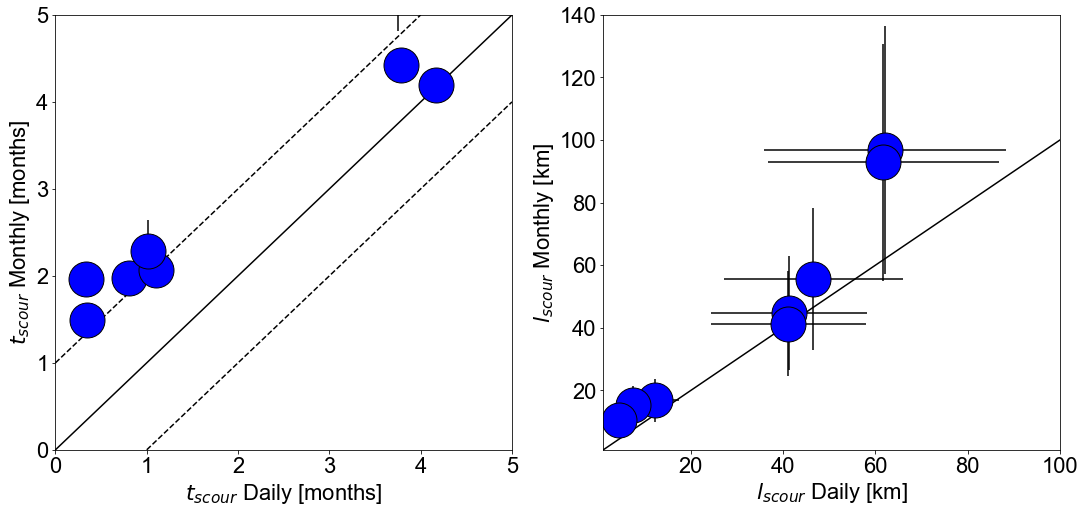

In [10]:
import pandas as pd

lscour_daily_monthly = pd.read_csv('./scour_data_output/daily_vs_monthly_data_comparison.csv') # Global compilation from Ganti et al. 2019

monthly_data = lscour_daily_monthly.loc[lscour_daily_monthly.tscour_data_res == 'MONTHLY']
daily_data = lscour_daily_monthly.loc[lscour_daily_monthly.tscour_data_res == 'DAILY']

daily_data = daily_data.sort_values('River', axis=0)
monthly_data = monthly_data.sort_values('River', axis=0)
                      
daily_tscour_months = daily_data['t_scour [months]']
daily_tscour_err = daily_data['t_scour_std_dev [months]']

monthly_tscour_months = monthly_data['t_scour [months]']
monthly_tscour_err = monthly_data['t_scour_std_dev [months]']

monthly_lscour_months = monthly_data['L_scour [km]']
monthly_lscour_err = monthly_data['L_scour_std_dev [km]']

daily_lscour_months = daily_data['L_scour [km]']
daily_lscour_err = daily_data['L_scour_std_dev [km]']

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(1, 2, figsize=(18, 8))
# ax.set_xscale("log", nonposx='clip')
# ax.set_yscale("log", nonposy='clip')

ax[0].errorbar(daily_tscour_months, monthly_tscour_months, yerr=monthly_tscour_err, xerr=daily_tscour_err, 
            fmt='o', ms=35, markerfacecolor='blue', ecolor='black',  markeredgecolor='black')
ax[0].set_xlim([0,5])
ax[0].set_ylim([0,5])
ax[0].plot([0,5],[0,5], 'k')
ax[0].plot([0,4],[1,5], 'k--')
ax[0].plot([1,5],[0,4], 'k--')
ax[0].set_xlabel('$t_{scour}$ Daily [months]')
ax[0].set_ylabel('$t_{scour}$ Monthly [months]')


ax[1].errorbar(daily_lscour_months, monthly_lscour_months, yerr=monthly_lscour_err, xerr=daily_lscour_err, 
            fmt='o', ms=35, markerfacecolor='blue', ecolor='black',  markeredgecolor='black')
# ax[1].set_xscale("log", nonposx='clip')
# ax[1].set_yscale("log", nonposy='clip')

ax[1].set_ylim(bottom=1, top=140)
ax[1].set_xlim(left=1, right=100)
# ax[1].set_xticks([10, 50, 100])

ax[1].plot([0,100],[0,100], 'k')
# ax[1].plot([0,4],[1,5], 'k--')
# ax[1].plot([1,5],[0,4], 'k--')
ax[1].set_xlabel('$l_{scour}$ Daily [km]')
ax[1].set_ylabel('$l_{scour}$ Monthly [km]')

plt.show()
fig.savefig('figures/daily_vs_monthly_comparison.pdf', transparent=True)

